# Text classification and sentiment analysis: Yelp Reviews

Once text data has been converted into numerical features using the natural language processing techniques discussed in the previous sections, text classification works just like any other classification task.

In this notebook, we will apply these preprocessing technique to Yelp business reviews to classify them by review scores and sentiment polarity. More specifically, we will apply sentiment analysis to the significantly larger Yelp business review dataset with five outcome classes. 

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import json
from time import time

import numpy as np
import pandas as pd

from scipy import sparse

# spacy, textblob and nltk for language processing
from textblob import TextBlob

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import joblib

import lightgbm as lgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
sns.set_style('white')
np.random.seed(42)

## Yelp Challenge: business reviews dataset

### Load Data

Follow the [instructions](../data/create_yelp_review_data.ipynb) to create the dataset. 

In [4]:
data_dir = Path('..', 'data', 'yelp')

In [5]:
yelp_reviews = pd.read_parquet(data_dir / 'user_reviews.parquet')

In [6]:
yelp_reviews.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8021122 entries, 0 to 8021121
Data columns (total 25 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   stars               8021122 non-null  float64
 1   useful              8021122 non-null  int64  
 2   funny               8021122 non-null  int64  
 3   cool                8021122 non-null  int64  
 4   text                8021122 non-null  object 
 5   year                8021122 non-null  int64  
 6   month               8021122 non-null  int64  
 7   review_count        8021122 non-null  int64  
 8   useful_user         8021122 non-null  int64  
 9   funny_user          8021122 non-null  int64  
 10  cool_user           8021122 non-null  int64  
 11  fans                8021122 non-null  int64  
 12  average_stars       8021122 non-null  float64
 13  compliment_hot      8021122 non-null  int64  
 14  compliment_more     8021122 non-null  int64  
 15  compliment_prof

### Explore data

In [13]:
yelp_dir = Path('results', 'yelp')

text_features_dir = yelp_dir / 'data'
if not text_features_dir.exists():
    text_features_dir.mkdir(exist_ok=True, parents=True)

The following figure shows the number of reviews and the average number of stars per year.

#### Reviews & Stars by Year

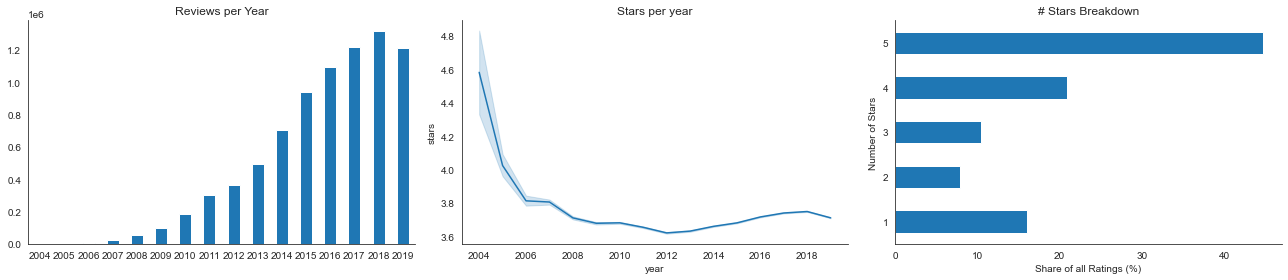

In [9]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 4))
yelp_reviews.year.value_counts().sort_index().plot.bar(title='Reviews per Year', ax=axes[0], rot=0);
sns.lineplot(x='year', y='stars', data=yelp_reviews, ax=axes[1])
axes[1].set_title('Stars per year')

stars_dist = yelp_reviews.stars.value_counts(normalize=True).sort_index().mul(100)
stars_dist.index = stars_dist.index.astype(int)
stars_dist.plot.barh(title='# Stars Breakdown', ax=axes[2])
axes[2].set_xlabel('Share of all Ratings (%)')
axes[2].set_ylabel('Number of Stars');

sns.despine()
fig.tight_layout();

#### Years of Membership Breakdown

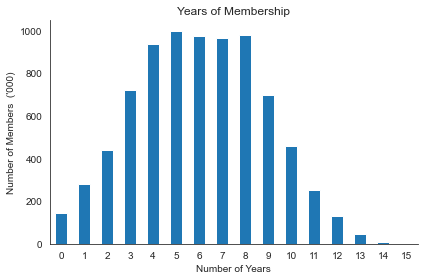

In [10]:
ax = yelp_reviews.member_yrs.value_counts().div(1000).sort_index().plot.bar(title='Years of Membership',
                                                                            rot=0)
ax.set_xlabel('Number of Years')
ax.set_ylabel("Number of Members  ('000)")
sns.despine()
plt.tight_layout()

### Create train-test split

In [11]:
train = yelp_reviews[yelp_reviews.year < 2019].sample(frac=.25)
test = yelp_reviews[yelp_reviews.year == 2019]

In [12]:
print(f'# Training Obs: {len(train):,.0f} | # Test Obs: {len(test):,.0f}')

# Training Obs: 1,701,322 | # Test Obs: 1,215,836


In [14]:
train.to_parquet(text_features_dir / 'train.parquet')
test.to_parquet(text_features_dir / 'test.parquet')

In [21]:
del yelp_reviews

#### Reload stored data

In [64]:
train = pd.read_parquet(text_features_dir / 'train.parquet')
test = pd.read_parquet(text_features_dir / 'test.parquet')

## Create Yelp review document-term matrix

In [16]:
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2), max_features=10000)
train_dtm = vectorizer.fit_transform(train.text)
train_dtm

<1701322x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 75720724 stored elements in Compressed Sparse Row format>

In [17]:
sparse.save_npz(text_features_dir / 'train_dtm', train_dtm)

In [18]:
test_dtm = vectorizer.transform(test.text)
sparse.save_npz(text_features_dir / 'test_dtm', test_dtm)

### Reload stored data

In [7]:
train_dtm = sparse.load_npz(text_features_dir / 'train_dtm.npz')
test_dtm = sparse.load_npz(text_features_dir / 'test_dtm.npz')

## Combine non-text features with the document-term matrix

The dataset contains various numerical features. The vectorizers produce [scipy.sparse matrices](https://docs.scipy.org/doc/scipy/reference/sparse.html). To combine the vectorized text data with other features, we need to first convert these to sparse matrices as well; many sklearn objects and other libraries like lightgbm can handle these very memory-efficient data structures. Converting the sparse matrix to a dense numpy array risks memory overflow.

Most variables are categorical so we use one-hot encoding since we have a fairly large dataset to accommodate the increase in features.

We convert the encoded numerical features and combine them with the document-term matrix:

### One-hot-encoding 

In [19]:
df = pd.concat([train.drop(['text', 'stars'], axis=1).assign(source='train'),
                test.drop(['text', 'stars'], axis=1).assign(source='test')])

In [20]:
uniques = df.nunique()
binned = pd.concat([(df.loc[:, uniques[uniques > 20].index]
                     .apply(pd.qcut, q=10, labels=False, duplicates='drop')),
                    df.loc[:, uniques[uniques <= 20].index]], axis=1)
binned.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917158 entries, 4906334 to 8021121
Data columns (total 24 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   useful              2917158 non-null  int64 
 1   funny               2917158 non-null  int64 
 2   cool                2917158 non-null  int64 
 3   review_count        2917158 non-null  int64 
 4   useful_user         2917158 non-null  int64 
 5   funny_user          2917158 non-null  int64 
 6   cool_user           2917158 non-null  int64 
 7   fans                2917158 non-null  int64 
 8   average_stars       2917158 non-null  int64 
 9   compliment_hot      2917158 non-null  int64 
 10  compliment_more     2917158 non-null  int64 
 11  compliment_profile  2917158 non-null  int64 
 12  compliment_cute     2917158 non-null  int64 
 13  compliment_list     2917158 non-null  int64 
 14  compliment_note     2917158 non-null  int64 
 15  compliment_plain    291715

In [22]:
dummies = pd.get_dummies(binned, 
                         columns=binned.columns.drop('source'), 
                         drop_first=True)
dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917158 entries, 4906334 to 8021121
Columns: 111 entries, source to member_yrs_15
dtypes: object(1), uint8(110)
memory usage: 350.5+ MB


In [23]:
train_dummies = dummies[dummies.source=='train'].drop('source', axis=1)
train_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1701322 entries, 4906334 to 4178053
Columns: 110 entries, useful_1 to member_yrs_15
dtypes: uint8(110)
memory usage: 191.5 MB


### Train set

In [24]:
# Cast other feature columns to float and convert to a sparse matrix.
train_numeric = sparse.csr_matrix(train_dummies.astype(np.uint8))
train_numeric.shape

(1701322, 110)

In [25]:
# Combine sparse matrices.
train_dtm_numeric = sparse.hstack((train_dtm, train_numeric))
train_dtm_numeric.shape

(1701322, 10110)

In [26]:
sparse.save_npz(text_features_dir / 'train_dtm_numeric', 
                train_dtm_numeric)

### Repeat for test set

In [27]:
test_dummies = dummies[dummies.source=='test'].drop('source', axis=1)
test_numeric = sparse.csr_matrix(test_dummies.astype(np.int8))
test_dtm_numeric = sparse.hstack((test_dtm, test_numeric))
test_dtm_numeric.shape

(1215836, 10110)

In [28]:
sparse.save_npz(text_features_dir / 'test_dtm_numeric', test_dtm_numeric)

### Reload stored data

In [ ]:
train_dtm_numeric = sparse.load_npz(text_features_dir / 'train_dtm_numeric.npz')
test_dtm_numeric = sparse.load_npz(text_features_dir / 'test_dtm_numeric.npz')

## Benchmark Accuracy

In [29]:
accuracy, runtime = {}, {}
predictions = test[['stars']].copy()

Using the most frequent number of stars (=5) to predict the test set achieve an accuracy close to 51%:

In [30]:
naive_prediction = np.full_like(predictions.stars,
                                fill_value=train.stars.mode().iloc[0])

In [31]:
naive_benchmark = accuracy_score(predictions.stars, naive_prediction)

In [32]:
naive_benchmark

0.5117779042568241

## Model Evaluation Helper

In [33]:
def evaluate_model(model, X_train, X_test, name, store=False):
    start = time()
    model.fit(X_train, train.stars)
    runtime[name] = time() - start
    predictions[name] = model.predict(X_test)
    accuracy[result] = accuracy_score(test.stars, predictions[result])
    if store:
        joblib.dump(model, f'results/{result}.joblib')

## Multiclass Naive Bayes

In [34]:
nb = MultinomialNB()

### Text Features

Next, we train a Naive Bayes classifier using a document-term matrix produced by the CountVectorizer with default settings.

In [35]:
result = 'nb_text'

In [36]:
evaluate_model(nb, train_dtm, test_dtm, result, store=False)

#### Accuracy

The prediction produces 64.4% accuracy on the test set, a 24.2% improvement over the benchmark:

In [37]:
accuracy[result]

0.6520747864021135

#### Confusion Matrix

In [38]:
stars = index = list(range(1, 6))
pd.DataFrame(confusion_matrix(test.stars, 
                              predictions[result]),
             columns=stars,
             index=stars)

,1,2,3,4,5
1,178787,42369,8419,3193,4295
2,26795,30224,18533,4445,3025
3,12420,17233,37337,21719,6319
4,7907,5608,21599,100153,43218
5,31323,3766,6762,134072,446315


### Text & Numeric Features

In [39]:
result = 'nb_combined'

In [40]:
evaluate_model(nb, train_dtm_numeric, test_dtm_numeric, result, store=False)

#### Accuracy

In [41]:
accuracy[result]

0.6739017433272251

## Multinomial Logistic Regression

Logistic regression also provides a multinomial training option that is faster and more accurate than the one-vs-all implementation. We use the lbfgs solver (see sklearn [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for details).

In [42]:
Cs = np.logspace(-5, 5, 11)

### Text Features

In [45]:
log_reg_text_accuracy = {}
log_reg_text_runtime = []
for i, C in enumerate(Cs):
    start = time()
    model = LogisticRegression(C=C,
                               multi_class='multinomial',
                               solver='lbfgs')

    model.fit(train_dtm, train.stars)
    log_reg_text_runtime.append(time() - start)
    log_reg_text_accuracy[C] = accuracy_score(test.stars,
                                              model.predict(test_dtm))

    print(f'{C:12.5f}: {log_reg_text_runtime[i]:.2f}s | {log_reg_text_accuracy[C]:.2%}', flush=True)

     0.00001: 34.93s | 62.02%
     0.00010: 74.01s | 70.89%
     0.00100: 126.02s | 73.95%
     0.01000: 122.22s | 74.85%
     0.10000: 125.65s | 74.80%
     1.00000: 130.17s | 74.83%
    10.00000: 126.39s | 74.80%
   100.00000: 125.82s | 74.81%
  1000.00000: 122.73s | 74.83%
 10000.00000: 123.29s | 74.80%
100000.00000: 126.80s | 74.80%


In [46]:
pd.Series(log_reg_text_accuracy).to_csv(yelp_dir / 'logreg_text.csv')

In [47]:
accuracy['lr_text'] = pd.Series(log_reg_text_accuracy).max()
runtime['lr_text'] = np.mean(log_reg_text_runtime)

### Combined Features

In [50]:
log_reg_comb_accuracy = {}
log_reg_comb_runtime = []
for i, C in enumerate(Cs):
    start = time()
    model = LogisticRegression(C=C,
                               multi_class='multinomial',
                               solver='lbfgs')

    model.fit(train_dtm_numeric, train.stars)
    log_reg_comb_runtime.append(time() - start)
    log_reg_comb_accuracy[C] = accuracy_score(test.stars,
                                              model.predict(test_dtm_numeric))

    print(f'{C:12.5f}: {log_reg_comb_runtime[i]:.2f}s | {log_reg_comb_accuracy[C]:.2%}', flush=True)

     0.00001: 55.26s | 63.98%
     0.00010: 99.05s | 72.94%
     0.00100: 137.62s | 75.12%
     0.01000: 139.11s | 75.55%
     0.10000: 140.26s | 75.28%
     1.00000: 138.90s | 75.32%
    10.00000: 135.13s | 75.35%
   100.00000: 137.76s | 75.32%
  1000.00000: 139.09s | 75.36%
 10000.00000: 135.01s | 75.37%
100000.00000: 134.73s | 75.38%


In [51]:
pd.Series(log_reg_comb_accuracy).to_csv(yelp_dir / 'logreg_combined.csv')

In [52]:
accuracy['lr_comb'] = pd.Series(log_reg_comb_accuracy).max()
runtime['lr_comb'] = np.mean(log_reg_comb_runtime)

## Gradient Boosting

For illustration, we also train a lightgbm Gradient Boosting tree ensemble with default settings and multiclass objective.

In [65]:
lgb_train = lgb.Dataset(data=train_dtm_numeric.tocsr().astype(np.float32), 
                        label=train.stars.sub(1), 
                        categorical_feature=list(range(train_dtm_numeric.shape[1])))

In [66]:
lgb_test = lgb.Dataset(data=test_dtm_numeric.tocsr().astype(np.float32), 
                       label=test.stars.sub(1), 
                       reference=lgb_train)

In [67]:
param = {'objective': 'multiclass',
         'metrics': ['multi_error'],
         'num_class': 5}

In [68]:
booster = lgb.train(params=param,
                    train_set=lgb_train,
                    num_boost_round=2000,
                    early_stopping_rounds=25,
                    valid_sets=[lgb_train, lgb_test],
                    verbose_eval=25)

Training until validation scores don't improve for 25 rounds
[25]	training's multi_error: 0.405759	valid_1's multi_error: 0.320156
[50]	training's multi_error: 0.370905	valid_1's multi_error: 0.297562
[75]	training's multi_error: 0.353564	valid_1's multi_error: 0.285789
[100]	training's multi_error: 0.34278	valid_1's multi_error: 0.278771
[125]	training's multi_error: 0.335184	valid_1's multi_error: 0.273733
[150]	training's multi_error: 0.329293	valid_1's multi_error: 0.269682
[175]	training's multi_error: 0.324728	valid_1's multi_error: 0.266682
[200]	training's multi_error: 0.320829	valid_1's multi_error: 0.264156
[225]	training's multi_error: 0.317401	valid_1's multi_error: 0.262016
[250]	training's multi_error: 0.314696	valid_1's multi_error: 0.259945
[275]	training's multi_error: 0.312185	valid_1's multi_error: 0.258219
[300]	training's multi_error: 0.3099	valid_1's multi_error: 0.256977
[325]	training's multi_error: 0.307957	valid_1's multi_error: 0.25591
[350]	training's multi_

In [69]:
booster.save_model((yelp_dir / 'lgb_model.txt').as_posix());

In [70]:
y_pred_class = booster.predict(test_dtm_numeric.astype(float))

The basic settings did not improve over the multinomial logistic regression, but further parameter tuning remains an unused option.

In [71]:
accuracy['lgb_comb'] = accuracy_score(test.stars, y_pred_class.argmax(1) + 1)

## Comparison

In [78]:
model_map = {'nb_combined': 'Naive Bayes',
             'lr_comb': 'Logistic Regression',
             'lgb_comb': 'LightGBM'}

In [97]:
accuracy_ = {model_map[k]: v for k, v in accuracy.items() if model_map.get(k)}

In [98]:
log_reg_text = pd.read_csv(yelp_dir / 'logreg_text.csv',
                       index_col=0,
                       squeeze=True)
log_reg_combined = pd.read_csv(yelp_dir / 'logreg_combined.csv',
                       index_col=0,
                       squeeze=True)

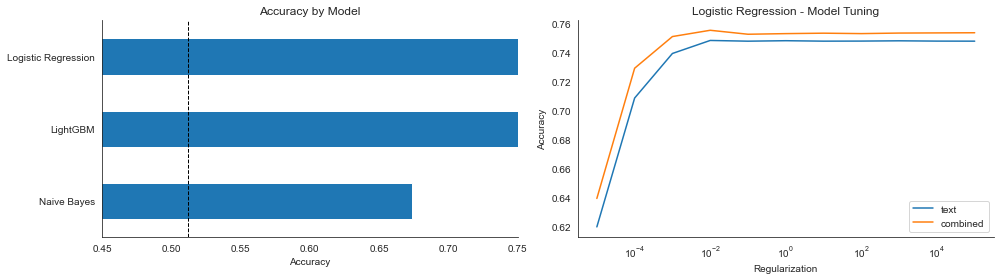

In [101]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
pd.Series(accuracy_).sort_values().plot.barh(
    ax=axes[0], xlim=(.45, .75), title='Accuracy by Model')
axes[0].axvline(naive_benchmark, ls='--', lw=1, c='k')


log_reg = (log_reg_text.to_frame('text')
           .join(log_reg_combined.to_frame('combined')))
log_reg.plot(logx=True,
             ax=axes[1],
             title='Logistic Regression - Model Tuning')
axes[1].set_xlabel('Regularization')
axes[1].set_ylabel('Accuracy')
axes[0].set_xlabel('Accuracy')
sns.despine()
fig.tight_layout()

## Textblob for Sentiment Analysis

In [84]:
sample_review = train.text.sample(1).iloc[0]
print(sample_review)

It's good to see new restaurants in Henderson along Stephanie Street, and judging by the packed parking lot a lot of people seem to like Miller's Ale House. I can't say that I'm a fan. I'll agree with Ashley B's review that it's better than Chili's and far better than suffering through Applebees, but it's really just a ho-hum nothing special chain restaurant with TV's plastered everywhere, and a boring menu of the same tired classics that can be easily prepared by a bunch of distracted teenagers working the kitchen. 

If you're hungry and the parking lot is not jammed and you can't decide on what to eat at least you can shut your stomach up if you stop here. But if you want something different or original remember this is a chain....you won't find what you're craving here. 

2 Stars...as in I was so underwhelmed by the place I almost fell asleep writing this one. Yawn!


In [85]:
# Polarity ranges from -1 (most negative) to 1 (most positive).
TextBlob(sample_review).sentiment.polarity

0.11637265512265516

In [86]:
# Define a function that accepts text and returns the polarity.
def detect_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [87]:
train['sentiment'] = train.text.apply(detect_sentiment)

In [88]:
sample_reviews = train[['stars', 'text']].sample(100000)

In [89]:
# Create a new DataFrame column for sentiment (Warning: SLOW!).
sample_reviews['sentiment'] = sample_reviews.text.apply(detect_sentiment)

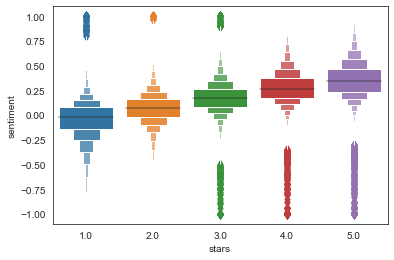

In [90]:
# Box plot of sentiment grouped by stars
sns.boxenplot(x='stars', y='sentiment', data=train);

In [91]:
# Widen the column display.
pd.set_option('max_colwidth', 500)

In [92]:
# Reviews with most negative sentiment
train[train.sentiment == -1].text.head()

2495072                                                  TERRIBLE!! I Ordered And They Just Cancelled My Order Because they "don't deliver to my hotel" no notice or anything just cancelled!!! I Was Waiting For My\nOrder for about an hour!
4807229                                                                                                              Don't bother to give them a call they did a no show for an estimate not even a phone call to let me know horrible service
4379860                                                                                                      horrible, horrible, horrible.  food, service price.  it's an overpriced tourist trap.  Pease do yourself a favor, go to in n out.
2941002                                                                                                           Well after my miserable experience they came with the rest of my furniture today. All broken and cracked! Dump!!!!!!!!!!!!!!
2785241    This is probably the worst experi

In [93]:
# Negative sentiment in a 5-star review
train.loc[(train.stars == 5) & (train.sentiment < -0.3), 'text'].head(1)

255057    Appointment set through Fidelity Home Warranty. Ken came out within a couple of hours. The capacitor was bad on one of my units and replaced immediately. Thank you Fidelity and Ken at Lee Collins Air.
Name: text, dtype: object

In [94]:
# Positive sentiment in a 1-star review
train.loc[(train.stars == 1) & (train.sentiment > 0.5), 'text'].head(1)

5373197    The food wasn't that great and the service was okay. We should have just gone to our go to spot Baby Stacks. The steak and eggs had no flavor and the potatoes were room temperature. I guess this is what happens when you want breakfast for dinner. The bill was $46 which is fine but if the food was actually good I don't think I would be as ann
Name: text, dtype: object

In [95]:
# Reset the column display width.
pd.reset_option('max_colwidth')